In [7]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from nn_tools import Qfirst, Qfollowing, optimiers_list, one_epoch_layers, EarlyStoppingList
import torch.nn as nn
from learning_tools import peak_one, algo_p, algo_e, update, assess_models
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
def learning_algo(data,max_iter=100, nb_layers=5, epsilon=0.1,
                  include_early_stopping = True, min_es_list = [1e-2]*5, patience_es_list = [100]*5,
                  loss= nn.MSELoss(),batch_size=50, device='cpu'):

    #### Initialisation des variables ####
    D = [[torch.empty(0), torch.empty(0)] for _ in range(nb_layers)]  # Un dataset D par couche
    all_actions = list(range(36))  # 36 actions possibles
    Q_models = [Qfirst() if i == 0 else Qfollowing() for i in range(nb_layers)]
    losses=[]
    if include_early_stopping:
        early_stop_list = EarlyStoppingList(min_es_list, patience_es_list)
    
    #### Boucle sur les epochs ####
    for _ in tqdm(range(max_iter)):
        #### Augmentation du dataset ####
        bidding_history = np.zeros(36) # array de 5x36 pour enregistrer l'historique des enchères
        x1, x2, scores = peak_one(data)

        for j in range(nb_layers):
            C = np.zeros(36)  
            hand = x1 if (j+1) % 2 == 1 else x2  # main du joueur actuel

            #### Calcul des coûts des actions: policy evaluation ####
            for i, action in enumerate(all_actions):
                C[i] = algo_p(action,x1,x2,scores,bidding_history,Q_models,nb_layers)
            
            # state = main si première couche sinon state = main + enchère_précédente
            state = torch.tensor(hand, dtype=torch.float32) if j == 0 else torch.tensor(np.concatenate([hand, bidding_history]), dtype=torch.float32)
            D=update(D,state,C,j) #ajout de l'expérience dans le dataset D_j
            
            #### Exploration ####
            next_a = algo_e(Q_models[j], state, epsilon, all_actions)  # Sélection avec Q_j
            if next_a == len(bidding_history) - 1:  # si l'action est PASS
                break  
            bidding_history[next_a] = 1  # enregistrement de l'action choisie dans l'historique des enchères

        #### Entraînement des modèles Q ####
        opti_list=optimiers_list(Q_models)
        losses.append(one_epoch_layers(Q_models, D, opti_list,loss, batch_size, device))
        if include_early_stopping and early_stop_list.test_stop(losses[-1], [Q.state_dict() for Q in Q_models]):
            early_stop_list.set_best_weights(Q_models)
            break
    return Q_models, np.array([np.array(l) for l in losses])

In [9]:
def plot_losses(losses, offset = 0):
    _, axs = plt.subplots(1,losses.shape[1], figsize = (4*losses.shape[1], 4))

    for k in range(losses.shape[1]):
        sns.lineplot(losses[offset:,k], ax=axs[k])
        axs[k].set_title(f"Loss {k}th layer")
    plt.tight_layout()
    plt.show()

In [10]:
data = pd.read_csv("data/slice0.csv", index_col = 0)

In [11]:
Q_models, losses = learning_algo(data, max_iter=100, min_es_list=[1e10]*5, patience_es_list= [10]*5)

  0%|          | 0/100 [00:00<?, ?it/s]

hand [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0.]
state tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 20
hand [0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 0. 1. 0. 0.]
state tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
        0., 0.,

  1%|          | 1/100 [00:15<25:28, 15.44s/it]

hand [0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0.]
state tensor([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 32
hand [0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0.]
state tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        0., 0.,

  2%|▏         | 2/100 [00:16<11:21,  6.96s/it]

hand [1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 0.]
state tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 18
hand [0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1.]
state tensor([0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0.,

  3%|▎         | 3/100 [00:16<06:25,  3.97s/it]

hand [1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1.]
state tensor([1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 20
hand [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 0.]
state tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0.,

  4%|▍         | 4/100 [00:17<04:24,  2.75s/it]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
next_a 35
hand [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 0.]
state tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
next_a 35
hand [0. 0. 0. 0. 0. 0.

  5%|▌         | 5/100 [00:18<02:56,  1.85s/it]

next_a 9
hand [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0.]
state tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 33
hand [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0.]
state tensor([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
      

  6%|▌         | 6/100 [00:19<02:29,  1.59s/it]

state tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
next_a 34
hand [0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 0. 0. 0.]
state tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 30
hand [0. 0. 0. 0.

  7%|▋         | 7/100 [00:20<02:15,  1.45s/it]

tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 35
hand [1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 1. 0.]
state tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 35
hand [1. 0. 0. 0. 0. 0.

  8%|▊         | 8/100 [00:21<01:58,  1.29s/it]

hand [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0.]
state tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 3
hand [0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0.]
state tensor([0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 

  9%|▉         | 9/100 [00:21<01:27,  1.04it/s]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
next_a 0
hand [0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0.]
state tensor([0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
next_a 0
hand [0. 1. 0. 0. 1. 1. 0

 10%|█         | 10/100 [00:22<01:24,  1.07it/s]

next_a 35
hand [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0.]
state tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
next_a 35
hand [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0.]
state tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
     

 11%|█         | 11/100 [00:23<01:19,  1.13it/s]

next_a 24
hand [0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
state tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 24
hand [0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
state tensor([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

 12%|█▏        | 12/100 [00:23<01:01,  1.43it/s]

next_a 35
hand [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 1.]
state tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 30
hand [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 0.]
state tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
     

 13%|█▎        | 13/100 [00:23<00:54,  1.61it/s]

tensor([0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
next_a 35
hand [0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 1.]
state tensor([0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])
next_a 35
hand [0. 0. 0. 1. 0. 1.

 14%|█▍        | 14/100 [00:24<00:54,  1.57it/s]

hand [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 0.]
state tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 30
hand [1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0.]
state tensor([1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0.,

 15%|█▌        | 15/100 [00:25<01:00,  1.40it/s]

next_a 35
hand [1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 1. 0. 0.]
state tensor([1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
next_a 35
hand [0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 0.]
state tensor([0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
     

 16%|█▌        | 16/100 [00:26<01:07,  1.24it/s]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
next_a 35
hand [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 0.]
state tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
next_a 35
hand [0. 0. 0. 1. 0. 0.

 17%|█▋        | 17/100 [00:27<01:02,  1.33it/s]

next_a 35
hand [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 0.]
state tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.])
next_a 35
hand [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 0.]
state tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
     

 18%|█▊        | 18/100 [00:28<01:06,  1.23it/s]

tensor([0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.])
next_a 0
hand [0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0.]
state tensor([0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])
next_a 35
hand [0. 0. 0. 1. 0. 1. 

 19%|█▉        | 19/100 [00:28<01:01,  1.31it/s]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
next_a 35
hand [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0.]
state tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
next_a 35
hand [1. 0. 0. 0. 0. 0.

 20%|██        | 20/100 [00:29<00:55,  1.44it/s]

state tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
next_a 35
hand [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0.]
state tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
next_a 35
hand [0. 0. 1. 0.

 21%|██        | 21/100 [00:29<00:52,  1.50it/s]

tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])
next_a 35
hand [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
state tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 30
hand [1. 0. 0. 0. 0. 0.

 22%|██▏       | 22/100 [00:30<00:59,  1.31it/s]

hand [0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0.]
state tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 30
hand [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0.]
state tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        0., 0.,

 23%|██▎       | 23/100 [00:31<01:05,  1.17it/s]

state tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.])
next_a 35
hand [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0.]
state tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0.])
next_a 35
hand [0. 0. 0. 0.

 24%|██▍       | 24/100 [00:32<01:04,  1.17it/s]

tensor([0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])
next_a 35
hand [1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0.]
state tensor([1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 30
hand [0. 0. 0. 1. 0. 0.

 24%|██▍       | 24/100 [00:33<01:45,  1.39s/it]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])
next_a 35
hand [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 1.]
state tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])
next_a 35
hand [0. 0. 0. 1. 0. 0.

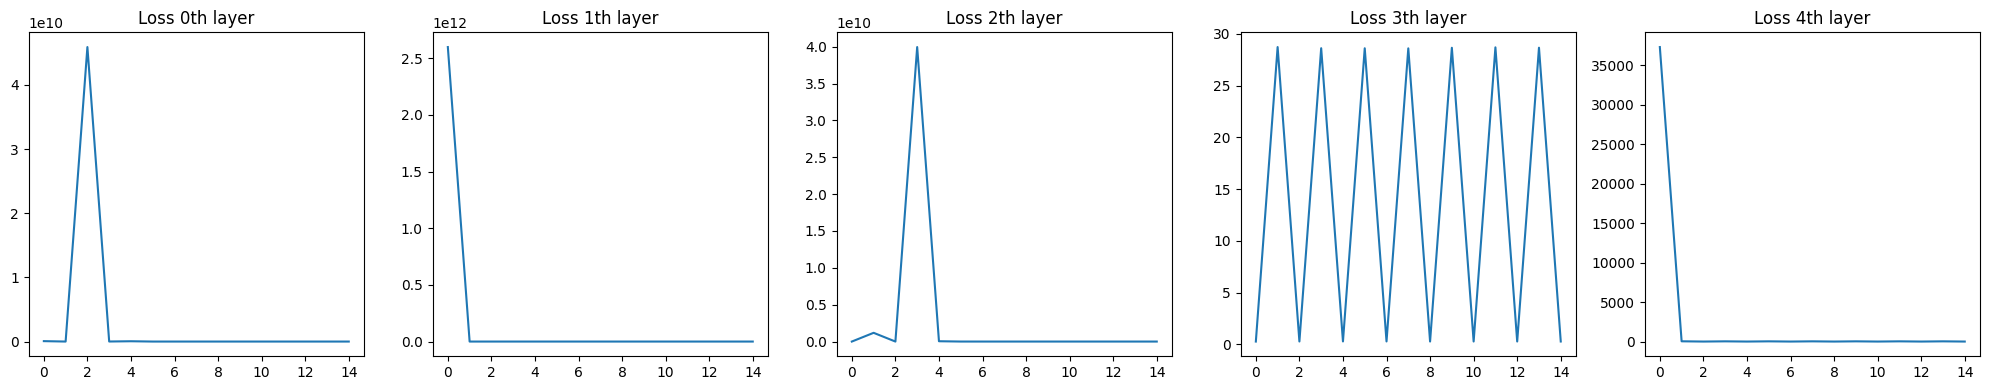

In [12]:
plot_losses(losses, offset=10)

In [ ]:
results = assess_models(Q_models, pd.read_csv("data/slice12.csv"))
results

  0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\admin\Desktop\Projet Reinforcement Deep\RL-for-bridge-bidding\learning_tools.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  state = torch.tensor(hand, dtype=torch.float32) if i == 0 else torch.tensor(np.concatenate([hand, bidding_history]), dtype=torch.float32)
c:\Users\admin\Desktop\Projet Reinforcement Deep\RL-for-bridge-bidding\learning_tools.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return scores[last_action], last_layer
  0%|          | 4/10000 [00:00<04:47, 34.78it/s]

hand Unnamed: 0    0.0
0             0.0
1             0.0
2             0.0
3             1.0
4             0.0
5             1.0
6             0.0
7             1.0
8             1.0
9             0.0
10            1.0
11            0.0
12            0.0
13            0.0
14            0.0
15            1.0
16            1.0
17            0.0
18            0.0
19            1.0
20            0.0
21            0.0
22            0.0
23            0.0
24            0.0
25            0.0
26            1.0
27            0.0
28            0.0
29            0.0
30            1.0
31            0.0
32            0.0
33            0.0
34            0.0
35            1.0
36            0.0
37            0.0
38            0.0
39            0.0
40            0.0
41            0.0
42            0.0
43            0.0
44            0.0
45            1.0
46            0.0
47            0.0
48            1.0
49            0.0
50            0.0
Name: 0, dtype: float64
state tensor([0., 0., 0., 0., 1., 0

  0%|          | 12/10000 [00:00<05:19, 31.30it/s]

next_a 30
hand Unnamed: 0    7.0
0             0.0
1             0.0
2             0.0
3             0.0
4             1.0
5             1.0
6             0.0
7             0.0
8             0.0
9             0.0
10            1.0
11            0.0
12            0.0
13            0.0
14            0.0
15            0.0
16            0.0
17            0.0
18            0.0
19            0.0
20            0.0
21            0.0
22            0.0
23            1.0
24            0.0
25            1.0
26            1.0
27            0.0
28            1.0
29            1.0
30            0.0
31            0.0
32            0.0
33            1.0
34            0.0
35            0.0
36            0.0
37            1.0
38            1.0
39            0.0
40            0.0
41            0.0
42            0.0
43            0.0
44            0.0
45            0.0
46            0.0
47            0.0
48            0.0
49            0.0
50            1.0
Name: 7, dtype: float64
state tensor([7., 0., 0.,

  0%|          | 16/10000 [00:00<05:45, 28.88it/s]

tensor([13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.])
next_a 29
hand 51     0.0
52     0.0
53     1.0
54     0.0
55     0.0
56     0.0
57     1.0
58     1.0
59     0.0
60     0.0
61     1.0
62     0.0
63     0.0
64     1.0
65     0.0
66     0.0
67     1.0
68     0.0
69     0.0
70     0.0
71     0.0
72     0.0
73     0.0
74     1.0
75     0.0
76     0.0
77     0.0
78     0.0
79     0.0
80     1.0
81     1.0
82     0.0
83     0.0
84     0.0
85     0.0
86     0.0
87     1.0
88     0.0
89     0.0
90     1.0
91     0.0
92     1.0
93     0.0
94     0.0
95     0.0
96     0.0
97     0.0
98     0.0
99     0.0
100    1.0
101    0.0
102    0.0
Name: 13, dtype: float64
state tensor([0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        0

  0%|          | 22/10000 [00:00<06:11, 26.83it/s]

hand Unnamed: 0    19.0
0              1.0
1              0.0
2              0.0
3              0.0
4              1.0
5              0.0
6              0.0
7              0.0
8              0.0
9              0.0
10             0.0
11             0.0
12             1.0
13             0.0
14             1.0
15             0.0
16             0.0
17             0.0
18             0.0
19             0.0
20             0.0
21             0.0
22             0.0
23             0.0
24             0.0
25             0.0
26             0.0
27             0.0
28             0.0
29             0.0
30             1.0
31             1.0
32             0.0
33             1.0
34             0.0
35             0.0
36             0.0
37             1.0
38             0.0
39             0.0
40             0.0
41             0.0
42             1.0
43             0.0
44             1.0
45             0.0
46             1.0
47             0.0
48             1.0
49             1.0
50             0.0
Name: 1

  0%|          | 28/10000 [00:00<06:21, 26.12it/s]

tensor([24.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
next_a 29
hand 51     0.0
52     0.0
53     0.0
54     0.0
55     0.0
56     0.0
57     0.0
58     0.0
59     0.0
60     0.0
61     0.0
62     0.0
63     0.0
64     1.0
65     0.0
66     1.0
67     0.0
68     0.0
69     1.0
70     0.0
71     0.0
72     0.0
73     0.0
74     0.0
75     0.0
76     1.0
77     1.0
78     0.0
79     0.0
80     0.0
81     0.0
82     0.0
83     0.0
84     1.0
85     1.0
86     0.0
87     1.0
88     0.0
89     0.0
90     1.0
91     1.0
92     0.0
93     0.0
94     0.0
95     0.0
96     0.0
97     1.0
98     0.0
99     1.0
100    1.0
101    0.0
102    0.0
Name: 24, dtype: float64
state tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1

  0%|          | 35/10000 [00:01<05:56, 27.91it/s]

next_a 29
hand 51     0.0
52     1.0
53     1.0
54     0.0
55     0.0
56     1.0
57     0.0
58     0.0
59     0.0
60     0.0
61     0.0
62     1.0
63     0.0
64     0.0
65     0.0
66     0.0
67     0.0
68     0.0
69     0.0
70     0.0
71     1.0
72     0.0
73     0.0
74     0.0
75     0.0
76     0.0
77     0.0
78     0.0
79     0.0
80     1.0
81     1.0
82     0.0
83     0.0
84     1.0
85     0.0
86     0.0
87     0.0
88     1.0
89     1.0
90     0.0
91     0.0
92     1.0
93     0.0
94     0.0
95     0.0
96     1.0
97     0.0
98     0.0
99     0.0
100    0.0
101    0.0
102    1.0
Name: 30, dtype: float64
state tensor([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.

  0%|          | 43/10000 [00:01<05:03, 32.81it/s]

tensor([37.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.])
next_a 29
hand 51     1.0
52     0.0
53     0.0
54     0.0
55     0.0
56     1.0
57     0.0
58     0.0
59     0.0
60     0.0
61     0.0
62     1.0
63     0.0
64     0.0
65     1.0
66     0.0
67     0.0
68     0.0
69     0.0
70     0.0
71     1.0
72     0.0
73     1.0
74     0.0
75     0.0
76     0.0
77     1.0
78     0.0
79     0.0
80     0.0
81     0.0
82     0.0
83     1.0
84     0.0
85     0.0
86     0.0
87     0.0
88     1.0
89     0.0
90     0.0
91     1.0
92     0.0
93     0.0
94     1.0
95     0.0
96     1.0
97     0.0
98     1.0
99     0.0
100    1.0
101    0.0
102    0.0
Name: 37, dtype: float64
state tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0

  1%|          | 51/10000 [00:01<05:04, 32.72it/s]

tensor([45.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.])
next_a 29
hand 51     0.0
52     0.0
53     0.0
54     0.0
55     0.0
56     0.0
57     0.0
58     1.0
59     0.0
60     0.0
61     0.0
62     1.0
63     0.0
64     0.0
65     0.0
66     0.0
67     1.0
68     0.0
69     0.0
70     0.0
71     0.0
72     1.0
73     0.0
74     0.0
75     1.0
76     1.0
77     1.0
78     0.0
79     0.0
80     0.0
81     0.0
82     1.0
83     1.0
84     0.0
85     0.0
86     1.0
87     0.0
88     0.0
89     1.0
90     0.0
91     0.0
92     1.0
93     0.0
94     0.0
95     0.0
96     0.0
97     0.0
98     0.0
99     0.0
100    0.0
101    0.0
102    1.0
Name: 45, dtype: float64
state tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0

  1%|          | 59/10000 [00:02<06:25, 25.78it/s]

state tensor([52.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.])
next_a 31
hand 51     0.0
52     0.0
53     0.0
54     0.0
55     0.0
56     0.0
57     1.0
58     1.0
59     1.0
60     1.0
61     0.0
62     1.0
63     0.0
64     0.0
65     0.0
66     1.0
67     0.0
68     0.0
69     0.0
70     0.0
71     0.0
72     0.0
73     0.0
74     0.0
75     0.0
76     0.0
77     0.0
78     0.0
79     1.0
80     0.0
81     0.0
82     0.0
83     0.0
84     0.0
85     0.0
86     0.0
87     1.0
88     0.0
89     1.0
90     0.0
91     0.0
92     0.0
93     1.0
94     0.

  1%|          | 63/10000 [00:02<06:03, 27.31it/s]

hand Unnamed: 0    59.0
0              1.0
1              1.0
2              0.0
3              0.0
4              0.0
5              0.0
6              1.0
7              0.0
8              0.0
9              0.0
10             0.0
11             1.0
12             1.0
13             0.0
14             1.0
15             1.0
16             0.0
17             0.0
18             0.0
19             0.0
20             0.0
21             0.0
22             0.0
23             1.0
24             0.0
25             1.0
26             0.0
27             0.0
28             0.0
29             1.0
30             0.0
31             0.0
32             0.0
33             0.0
34             0.0
35             0.0
36             0.0
37             1.0
38             0.0
39             0.0
40             0.0
41             0.0
42             1.0
43             0.0
44             1.0
45             0.0
46             0.0
47             0.0
48             0.0
49             0.0
50             0.0
Name: 5

  1%|          | 72/10000 [00:02<05:20, 30.93it/s]

next_a 30
hand Unnamed: 0    65.0
0              1.0
1              0.0
2              1.0
3              1.0
4              1.0
5              1.0
6              0.0
7              0.0
8              0.0
9              1.0
10             0.0
11             0.0
12             0.0
13             1.0
14             0.0
15             1.0
16             0.0
17             0.0
18             0.0
19             0.0
20             0.0
21             0.0
22             0.0
23             0.0
24             0.0
25             0.0
26             0.0
27             1.0
28             1.0
29             0.0
30             0.0
31             0.0
32             0.0
33             0.0
34             0.0
35             1.0
36             0.0
37             0.0
38             0.0
39             1.0
40             0.0
41             0.0
42             0.0
43             0.0
44             0.0
45             0.0
46             0.0
47             0.0
48             1.0
49             0.0
50             0

  1%|          | 76/10000 [00:02<05:09, 32.12it/s]

hand Unnamed: 0    72.0
0              0.0
1              0.0
2              0.0
3              0.0
4              0.0
5              1.0
6              0.0
7              1.0
8              0.0
9              1.0
10             0.0
11             1.0
12             0.0
13             1.0
14             0.0
15             0.0
16             0.0
17             0.0
18             0.0
19             0.0
20             0.0
21             1.0
22             0.0
23             0.0
24             1.0
25             0.0
26             0.0
27             0.0
28             0.0
29             1.0
30             0.0
31             0.0
32             0.0
33             1.0
34             0.0
35             0.0
36             0.0
37             1.0
38             0.0
39             1.0
40             0.0
41             0.0
42             0.0
43             1.0
44             0.0
45             0.0
46             0.0
47             1.0
48             0.0
49             0.0
50             0.0
Name: 7

  1%|          | 86/10000 [00:02<04:23, 37.61it/s]

tensor([80.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.])
next_a 12
hand 51     0.0
52     0.0
53     0.0
54     0.0
55     0.0
56     0.0
57     0.0
58     0.0
59     1.0
60     0.0
61     1.0
62     1.0
63     0.0
64     0.0
65     1.0
66     0.0
67     0.0
68     0.0
69     0.0
70     0.0
71     1.0
72     0.0
73     0.0
74     0.0
75     0.0
76     0.0
77     1.0
78     1.0
79     0.0
80     0.0
81     0.0
82     1.0
83     0.0
84     0.0
85     0.0
86     0.0
87     0.0
88     0.0
89     0.0
90     1.0
91     1.0
92     0.0
93     0.0
94     1.0
95     0.0
96     0.0
97     0.0
98     0.0
99     1.0
100    0.0
101    1.0
102    0.0
Name: 80, dtype: float64
state tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
        0

  1%|          | 96/10000 [00:03<04:00, 41.24it/s]

tensor([89.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.])
next_a 12
hand 51     0.0
52     1.0
53     0.0
54     0.0
55     0.0
56     0.0
57     0.0
58     1.0
59     0.0
60     0.0
61     0.0
62     0.0
63     1.0
64     0.0
65     0.0
66     0.0
67     1.0
68     0.0
69     0.0
70     1.0
71     0.0
72     1.0
73     1.0
74     0.0
75     0.0
76     0.0
77     1.0
78     1.0
79     1.0
80     0.0
81     0.0
82     0.0
83     0.0
84     0.0
85     0.0
86     0.0
87     0.0
88     0.0
89     0.0
90     0.0
91     1.0
92     1.0
93     0.0
94     0.0
95     0.0
96     0.0
97     0.0
98     0.0
99     0.0
100    1.0
101    0.0
102    0.0
Name: 89, dtype: float64
state tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
        0

  1%|          | 101/10000 [00:03<04:07, 39.95it/s]

tensor([98.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])
next_a 12
hand 51     0.0
52     0.0
53     0.0
54     0.0
55     1.0
56     0.0
57     0.0
58     0.0
59     0.0
60     1.0
61     1.0
62     1.0
63     0.0
64     0.0
65     0.0
66     0.0
67     0.0
68     0.0
69     0.0
70     1.0
71     0.0
72     1.0
73     0.0
74     1.0
75     1.0
76     0.0
77     0.0
78     1.0
79     0.0
80     0.0
81     0.0
82     0.0
83     1.0
84     0.0
85     0.0
86     0.0
87     0.0
88     0.0
89     0.0
90     0.0
91     1.0
92     0.0
93     1.0
94     0.0
95     0.0
96     0.0
97     0.0
98     0.0
99     0.0
100    0.0
101    0.0
102    1.0
Name: 98, dtype: float64
state tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0

  1%|          | 113/10000 [00:03<03:36, 45.65it/s]

hand Unnamed: 0    107.0
0               0.0
1               0.0
2               1.0
3               1.0
4               1.0
5               1.0
6               1.0
7               1.0
8               1.0
9               0.0
10              0.0
11              0.0
12              0.0
13              0.0
14              0.0
15              0.0
16              0.0
17              1.0
18              0.0
19              0.0
20              0.0
21              0.0
22              0.0
23              0.0
24              0.0
25              0.0
26              0.0
27              0.0
28              0.0
29              1.0
30              0.0
31              0.0
32              0.0
33              0.0
34              0.0
35              1.0
36              0.0
37              0.0
38              0.0
39              1.0
40              1.0
41              0.0
42              0.0
43              0.0
44              0.0
45              0.0
46              0.0
47              1.0
48             

  1%|          | 124/10000 [00:03<03:31, 46.67it/s]

tensor([117.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   0.,   1.,
          0.,   0.,   0.,   1.])
next_a 3
hand 51     0.0
52     0.0
53     1.0
54     0.0
55     0.0
56     0.0
57     0.0
58     0.0
59     0.0
60     1.0
61     0.0
62     0.0
63     0.0
64     0.0
65     0.0
66     0.0
67     1.0
68     0.0
69     1.0
70     0.0
71     1.0
72     0.0
73     0.0
74     1.0
75     0.0
76     1.0
77     0.0
78     0.0
79     0.0
80     1.0
81     0.0
82     1.0
83     1.0
84     0.0
85     0.0
86     1.0
87     0.0
88     0.0
89     0.0
90     0.0
91     0.0
92     1.0
93     0.0
94     0.0
95     0.0
96     0.0
97     0.0
98     0.0
99     0.0
100    0.0
101    0.0
102    0.0
Name: 117, dtype: float64
state tensor([0., 0., 1., 0., 0., 0

  1%|▏         | 129/10000 [00:03<03:36, 45.57it/s]

state tensor([1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
next_a 35
hand Unnamed: 0    127.0
0               1.0
1               0.0
2               0.0
3               1.0
4               0.0
5               0.0
6               1.0
7               0.0
8               1.0
9               1.0
10              1.0
11              1.0
12              1.0
13              0.0
14              0.0
15              0.0
16              0.0
17              0.0
18              1.0
19              0.0
20              0.0
21              0.0
22              0.0
23              0.0
24              0.0
25              0.0
26              0.0
27              0.0
28    

  1%|▏         | 139/10000 [00:04<04:08, 39.66it/s]

next_a 35
hand Unnamed: 0    133.0
0               0.0
1               0.0
2               0.0
3               0.0
4               1.0
5               0.0
6               0.0
7               0.0
8               1.0
9               0.0
10              0.0
11              0.0
12              1.0
13              1.0
14              1.0
15              1.0
16              1.0
17              0.0
18              0.0
19              0.0
20              0.0
21              0.0
22              0.0
23              1.0
24              0.0
25              0.0
26              0.0
27              0.0
28              0.0
29              0.0
30              1.0
31              0.0
32              0.0
33              1.0
34              0.0
35              1.0
36              0.0
37              0.0
38              0.0
39              0.0
40              0.0
41              0.0
42              0.0
43              0.0
44              0.0
45              0.0
46              0.0
47              0.0
48   

  1%|▏         | 149/10000 [00:04<04:00, 41.04it/s]

state tensor([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
next_a 35
hand Unnamed: 0    142.0
0               0.0
1               0.0
2               0.0
3               1.0
4               0.0
5               0.0
6               0.0
7               0.0
8               0.0
9               0.0
10              1.0
11              0.0
12              0.0
13              0.0
14              1.0
15              0.0
16              0.0
17              0.0
18              0.0
19              0.0
20              0.0
21              0.0
22              0.0
23              0.0
24              0.0
25              1.0
26              0.0
27              0.0
28    

  2%|▏         | 160/10000 [00:04<03:36, 45.55it/s]

tensor([151.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,
          1.,   0.,   1.,   0.])
next_a 3
hand 51     1.0
52     1.0
53     0.0
54     0.0
55     0.0
56     0.0
57     0.0
58     0.0
59     1.0
60     0.0
61     1.0
62     0.0
63     0.0
64     0.0
65     0.0
66     1.0
67     1.0
68     0.0
69     0.0
70     0.0
71     1.0
72     0.0
73     0.0
74     0.0
75     0.0
76     0.0
77     0.0
78     0.0
79     0.0
80     0.0
81     0.0
82     1.0
83     0.0
84     1.0
85     0.0
86     0.0
87     0.0
88     0.0
89     1.0
90     1.0
91     0.0
92     0.0
93     1.0
94     0.0
95     0.0
96     0.0
97     0.0
98     0.0
99     0.0
100    1.0
101    0.0
102    1.0
Name: 151, dtype: float64
state tensor([1., 1., 0., 0., 0., 0

  2%|▏         | 165/10000 [00:04<03:39, 44.80it/s]

tensor([161.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.])
next_a 31
hand 51     1.0
52     0.0
53     0.0
54     0.0
55     0.0
56     0.0
57     0.0
58     1.0
59     0.0
60     0.0
61     1.0
62     0.0
63     0.0
64     0.0
65     0.0
66     0.0
67     1.0
68     0.0
69     0.0
70     0.0
71     0.0
72     0.0
73     1.0
74     0.0
75     0.0
76     1.0
77     0.0
78     1.0
79     0.0
80     0.0
81     1.0
82     0.0
83     0.0
84     0.0
85     0.0
86     

  2%|▏         | 170/10000 [00:04<05:28, 29.94it/s]

next_a 12
hand 51     0.0
52     0.0
53     1.0
54     1.0
55     0.0
56     0.0
57     1.0
58     1.0
59     0.0
60     1.0
61     0.0
62     0.0
63     0.0
64     0.0
65     0.0
66     0.0
67     1.0
68     1.0
69     0.0
70     0.0
71     0.0
72     0.0
73     0.0
74     0.0
75     0.0
76     0.0
77     1.0
78     0.0
79     0.0
80     0.0
81     0.0
82     0.0
83     1.0
84     0.0
85     1.0
86     0.0
87     0.0
88     0.0
89     0.0
90     0.0
91     0.0
92     0.0
93     0.0
94     1.0
95     1.0
96     0.0
97     0.0
98     0.0
99     0.0
100    0.0
101    0.0
102    0.0
Name: 167, dtype: float64
state tensor([0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

  2%|▏         | 174/10000 [00:05<05:43, 28.63it/s]

state tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])
next_a 35
hand Unnamed: 0    172.0
0               0.0
1               0.0
2               0.0
3               0.0
4               1.0
5               0.0
6               0.0
7               1.0
8               0.0
9               0.0
10              1.0
11              0.0
12              0.0
13              1.0
14              0.0
15              0.0
16              0.0
17              0.0
18              0.0
19              0.0
20              1.0
21              0.0
22              0.0
23              0.0
24              0.0
25              0.0
26              0.0
27              0.0
28    

  2%|▏         | 184/10000 [00:05<04:45, 34.35it/s]

state tensor([179.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.])
next_a 35
hand Unnamed: 0    180.0
0               0.0
1               0.0
2               1.0
3               1.0
4               0.0
5               1.0
6               0.0
7               0.0
8               0.0
9               0.0
10              0.0
11              1.0
12              1.0
13              0.0
14              0.0
15              0.0
16              1.0
17              0.0
18    

  2%|▏         | 194/10000 [00:05<04:14, 38.53it/s]

state tensor([188.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,   1.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.])
next_a 31
hand 51     0.0
52     0.0
53     1.0
54     0.0
55     0.0
56     0.0
57     0.0
58     0.0
59     1.0
60     0.0
61     0.0
62     0.0
63     1.0
64     0.0
65     0.0
66     0.0
67     1.0
68     0.0
69     0.0
70     0.0
71     0.0
72     0.0
73     1.0
74     1.0
75     0.0
76     1.0
77     1.0
78     0.0
79     1.0
80     0.0
81     0.0
82     1.0
83     0.0
84     1.0
85     0.0
8

  2%|▏         | 199/10000 [00:05<04:52, 33.55it/s]

state tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 30
hand Unnamed: 0    197.0
0               0.0
1               0.0
2               1.0
3               0.0
4               0.0
5               0.0
6               0.0
7               1.0
8               0.0
9               0.0
10              1.0
11              1.0
12              1.0
13              0.0
14              1.0
15              0.0
16              0.0
17              0.0
18              0.0
19              0.0
20              0.0
21              0.0
22              0.0
23              0.0
24              1.0
25              0.0
26              0.0
27              0.0
28    

  2%|▏         | 209/10000 [00:05<04:16, 38.17it/s]

state tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 30
hand Unnamed: 0    202.0
0               1.0
1               0.0
2               0.0
3               0.0
4               0.0
5               0.0
6               0.0
7               1.0
8               0.0
9               1.0
10              1.0
11              0.0
12              0.0
13              0.0
14              1.0
15              1.0
16              0.0
17              0.0
18              0.0
19              0.0
20              1.0
21              0.0
22              0.0
23              0.0
24              0.0
25              0.0
26              1.0
27              0.0
28    

  2%|▏         | 222/10000 [00:06<03:16, 49.72it/s]

state tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 30
hand Unnamed: 0    212.0
0               0.0
1               0.0
2               0.0
3               1.0
4               0.0
5               0.0
6               1.0
7               0.0
8               0.0
9               0.0
10              0.0
11              0.0
12              0.0
13              1.0
14              0.0
15              0.0
16              0.0
17              1.0
18              0.0
19              0.0
20              1.0
21              0.0
22              0.0
23              1.0
24              0.0
25              0.0
26              1.0
27              0.0
28    

  2%|▏         | 234/10000 [00:06<03:06, 52.38it/s]

state tensor([0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
next_a 30
hand Unnamed: 0    224.0
0               0.0
1               1.0
2               0.0
3               0.0
4               1.0
5               0.0
6               0.0
7               0.0
8               0.0
9               0.0
10              0.0
11              0.0
12              1.0
13              0.0
14              0.0
15              0.0
16              0.0
17              0.0
18              1.0
19              0.0
20              0.0
21              1.0
22              1.0
23              1.0
24              0.0
25              0.0
26              0.0
27              0.0
28    

  2%|▏         | 240/10000 [00:06<03:00, 53.96it/s]

tensor([236.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.])
next_a 35
hand Unnamed: 0    237.0
0               0.0
1               0.0
2               1.0
3               0.0
4               0.0
5               1.0
6               0.0
7               1.0
8               0.0
9               0.0
10              1.0
11              1.0
12              0.0
13              0.0
14              1.0
15              0.0
16              0.0
17              0.0
18              1.0
19              0.0
20              0.0
21              0.0
22              0.0
23              0.0
24              0.0
25              1.0
26              0.0
27              0.0
28              0.0
29              0.0
30          

  3%|▎         | 253/10000 [00:06<03:02, 53.33it/s]

hand Unnamed: 0    246.0
0               0.0
1               0.0
2               1.0
3               1.0
4               0.0
5               1.0
6               1.0
7               0.0
8               0.0
9               0.0
10              0.0
11              0.0
12              0.0
13              1.0
14              0.0
15              1.0
16              0.0
17              1.0
18              0.0
19              0.0
20              0.0
21              0.0
22              1.0
23              0.0
24              1.0
25              0.0
26              0.0
27              0.0
28              0.0
29              0.0
30              0.0
31              0.0
32              0.0
33              0.0
34              0.0
35              0.0
36              0.0
37              0.0
38              0.0
39              0.0
40              0.0
41              0.0
42              1.0
43              1.0
44              1.0
45              0.0
46              0.0
47              1.0
48             

  3%|▎         | 266/10000 [00:06<02:48, 57.61it/s]

tensor([258.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   1.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.])
next_a 10
hand 51     0.0
52     0.0
53     1.0
54     1.0
55     1.0
56     0.0
57     0.0
58     0.0
59     0.0
60     1.0
61     0.0
62     0.0
63     0.0
64     1.0
65     0.0
66     0.0
67     0.0
68     0.0
69     1.0
70     1.0
71     1.0
72     0.0
73     0.0
74     0.0
75     0.0
76     0.0
77     1.0
78     0.0
79     0.0
80     0.0
81     0.0
82     0.0
83     0.0
84     0.0
85     0.0
86     0.0
87     0.0
88     1.0
89     1.0
90     0.0
91     0.0
92     0.0
93     0.0
94     1.0
95     0.0
96     0.0
97     0.0
98     0.0
99     0.0
100    0.0
101    0.0
102    0.0
Name: 258, dtype: float64
state tensor([0., 0., 1., 1., 1., 

  3%|▎         | 274/10000 [00:07<03:26, 47.10it/s]

state tensor([272.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.])
next_a 35
hand Unnamed: 0    273.0
0               1.0
1               0.0
2               0.0
3               1.0
4               0.0
5               0.0
6               0.0
7               0.0
8               0.0
9               0.0
10              1.0
11              0.0
12              0.0
13              0.0
14              1.0
15              0.0
16              0.0
17              0.0
18    

  3%|▎         | 280/10000 [00:07<03:57, 40.95it/s]

tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
next_a 35
hand Unnamed: 0    275.0
0               0.0
1               0.0
2               0.0
3               0.0
4               0.0
5               0.0
6               0.0
7               0.0
8               0.0
9               0.0
10              1.0
11              1.0
12              0.0
13              0.0
14              0.0
15              0.0
16              1.0
17              0.0
18              0.0
19              0.0
20              0.0
21              0.0
22              0.0
23              0.0
24              1.0
25              0.0
26              1.0
27              1.0
28          

  3%|▎         | 295/10000 [00:07<03:07, 51.72it/s]

state tensor([1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.])
next_a 35
hand Unnamed: 0    283.0
0               0.0
1               0.0
2               1.0
3               1.0
4               0.0
5               1.0
6               0.0
7               0.0
8               0.0
9               0.0
10              0.0
11              1.0
12              0.0
13              0.0
14              0.0
15              1.0
16              0.0
17              0.0
18              1.0
19              0.0
20              0.0
21              0.0
22              0.0
23              0.0
24              0.0
25              0.0
26              0.0
27              1.0
28    

  3%|▎         | 301/10000 [00:07<03:10, 51.02it/s]

tensor([297.,   0.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   1.])
next_a 10
hand 51     1.0
52     0.0
53     0.0
54     0.0
55     0.0
56     1.0
57     0.0
58     0.0
59     0.0
60     0.0
61     1.0
62     0.0
63     0.0
64     1.0
65     1.0
66     0.0
67     0.0
68     0.0
69     0.0
70     0.0
71     0.0
72     1.0
73     0.0
74     1.0
75     1.0
76     0.0
77     0.0
78     0.0
79     0.0
80     1.0
81     0.0
82     0.0
83     1.0
84     0.0
85     0.0
86     0.0
87     0.0
88     1.0
89     0.0
90     0.0
91     1.0
92     0.0
93     0.0
94     0.0
95     0.0
96     0.0
97     1.0
98     0.0
99     0.0
100    0.0
101    1.0
102    0.0
Name: 297, dtype: float64
state tensor([1., 0., 0., 0., 0., 

  3%|▎         | 312/10000 [00:08<03:45, 43.00it/s]

tensor([306.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.])
next_a 3
hand 51     0.0
52     0.0
53     0.0
54     0.0
55     1.0
56     0.0
57     0.0
58     0.0
59     0.0
60     0.0
61     1.0
62     1.0
63     0.0
64     0.0
65     1.0
66     0.0
67     0.0
68     0.0
69     1.0
70     1.0
71     1.0
72     1.0
73     0.0
74     0.0
75     0.0
76     0.0
77     0.0
78     0.0
79     0.0
80     0.0
81     0.0
82     0.0
83     0.0
84     1.0
85     0.0
86     0.0
87     0.0
88     1.0
89     0.0
90     1.0
91     0.0
92     0.0
93     1.0
94     0.0
95     0.0
96     0.0
97     0.0
98     0.0
99     0.0
100    0.0
101    0.0
102    0.0
Name: 306, dtype: float64
state tensor([0., 0., 0., 0., 1., 0

  3%|▎         | 326/10000 [00:08<03:03, 52.65it/s]

state tensor([313.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.])
next_a 35
hand Unnamed: 0    314.0
0               1.0
1               0.0
2               1.0
3               0.0
4               1.0
5               0.0
6               0.0
7               0.0
8               0.0
9               0.0
10              0.0
11              1.0
12              0.0
13              1.0
14              1.0
15              0.0
16              0.0
17              1.0
18    

  3%|▎         | 334/10000 [00:08<02:49, 57.19it/s]

next_a 10
hand 51     0.0
52     1.0
53     0.0
54     0.0
55     0.0
56     0.0
57     1.0
58     1.0
59     1.0
60     0.0
61     0.0
62     0.0
63     0.0
64     0.0
65     0.0
66     0.0
67     0.0
68     1.0
69     1.0
70     1.0
71     0.0
72     0.0
73     0.0
74     0.0
75     0.0
76     0.0
77     1.0
78     1.0
79     0.0
80     0.0
81     0.0
82     1.0
83     0.0
84     0.0
85     0.0
86     0.0
87     0.0
88     0.0
89     0.0
90     1.0
91     0.0
92     0.0
93     0.0
94     0.0
95     1.0
96     0.0
97     0.0
98     0.0
99     0.0
100    0.0
101    1.0
102    0.0
Name: 328, dtype: float64
state tensor([0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

  3%|▎         | 347/10000 [00:08<02:45, 58.42it/s]

hand Unnamed: 0    340.0
0               1.0
1               0.0
2               0.0
3               1.0
4               0.0
5               0.0
6               1.0
7               0.0
8               0.0
9               1.0
10              0.0
11              1.0
12              0.0
13              0.0
14              0.0
15              0.0
16              0.0
17              1.0
18              1.0
19              0.0
20              0.0
21              1.0
22              0.0
23              0.0
24              0.0
25              1.0
26              0.0
27              1.0
28              0.0
29              0.0
30              1.0
31              0.0
32              0.0
33              0.0
34              1.0
35              0.0
36              0.0
37              1.0
38              0.0
39              0.0
40              0.0
41              0.0
42              0.0
43              0.0
44              0.0
45              0.0
46              0.0
47              0.0
48             

  4%|▎         | 354/10000 [00:08<02:37, 61.40it/s]